# Import data and set environment

In [2]:
# Import packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pickle
import math as math
from matplotlib import gridspec
import os
import seaborn as sns
%matplotlib inline
import pandas as pd
from scipy import stats

In [3]:
#Set figure style

%matplotlib inline
plt.style.use("seaborn-white")
# plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 6
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = 'Arial'
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]
plt.rcParams["figure.dpi"] = 200
plt.rcParams['grid.color'] = 'white'

In [4]:
# Load model functions
def signal_periodic(signal_number,t,slope_on,slope_off):
    p = signal_number
    if (p/2)*slope_on < 1:
        maxs = (p/2)*slope_on
    else:
        maxs = 1
        
    if signal_number == 0:
        return 0
    elif signal_number == 1:
        if t < 1/slope_on:
            return t*slope_on
        else:
            return 1
    else :
        it = math.floor(t/signal_number)
        if t>=it*p and t < it*p+p/2:
            if t >= it*p and t < it*p+(1/slope_on):
                return ((t-it*p)*slope_on)
            else:
                return 1
        else:
            return 0
def signal_single(signal_number,t,slope_on,slope_off):
    p = signal_number
    if (p)*slope_on < 1:
        maxs = (p)*slope_on
    else:
        maxs = 1
        
    if signal_number == 0:
        return 0
    elif signal_number == 1:
        if t < 1/slope_on:
            return t*slope_on
        else:
            return 1
    else :
        if t < p:
            if t <= p and t < (1/slope_on):
                return ((t)*slope_on)
            else:
                return 1
        else:
            return 0
            
def DE_periodic(y,t,signal_number,slope_on,slope_off):
    GFP, Fus3, ppFus3, Ste12, Ste12Digs, Far1, pFar1 = y

    s=signal_periodic(signal_number,t,slope_on,slope_off)

    # GFP
    dGFPdt = ksynGFP+(ka4*Ste12**hc)/(KGFP+Ste12**hc)-kdegGFP*GFP
    # Fus3
    dFus3dt = ksynF3+(kfb1*Ste12**hc)/(KFus3+Ste12**hc)-kp1*s*Fus3+kp2*ppFus3-kdegF3*Fus3
    # ppFus3
    dppFus3dt = kp1*s*Fus3-kp2*ppFus3
    # Ste12
    dSte12dt = ksynS12+(kfb2*Ste12**hc)/(KSte12+Ste12**hc)-kdegS12*Ste12*(1+(kff*pFar1)/(km1+pFar1))-ka1*Ste12*(DigsT-Ste12Digs)+(ka2*ppFus3+ka3)*Ste12Digs
    # Ste12Digs
    dSte12Digsdt = ka1*Ste12*(DigsT-Ste12Digs)-(ka2*ppFus3+ka3+kdegS12D)*Ste12Digs
    # Far1
    dFar1dt = ksynF1+(ka5*Ste12**hc)/(KFar1+Ste12**hc)+kp3*pFar1-kp4*ppFus3*Far1-kdegF1*Far1
    # pFar1
    dpFar1dt = kp4*ppFus3*Far1-kp3*pFar1-kdegPF1*pFar1

    return [dGFPdt, dFus3dt, dppFus3dt, dSte12dt, dSte12Digsdt, dFar1dt, dpFar1dt]
def DE_single(y,t,signal_number,slope_on,slope_off):
    GFP, Fus3, ppFus3, Ste12, Ste12Digs, Far1, pFar1 = y

    s=signal_single(signal_number,t,slope_on,slope_off)

    # GFP
    dGFPdt = ksynGFP+(ka4*Ste12**hc)/(KGFP+Ste12**hc)-kdegGFP*GFP
    # Fus3
    dFus3dt = ksynF3+(kfb1*Ste12**hc)/(KFus3+Ste12**hc)-kp1*s*Fus3+kp2*ppFus3-kdegF3*Fus3
    # ppFus3
    dppFus3dt = kp1*s*Fus3-kp2*ppFus3
    # Ste12
    dSte12dt = ksynS12+(kfb2*Ste12**hc)/(KSte12+Ste12**hc)-kdegS12*Ste12*(1+(kff*pFar1)/(km1+pFar1))-ka1*Ste12*(DigsT-Ste12Digs)+(ka2*ppFus3+ka3)*Ste12Digs
    # Ste12Digs
    dSte12Digsdt = ka1*Ste12*(DigsT-Ste12Digs)-(ka2*ppFus3+ka3+kdegS12D)*Ste12Digs
    # Far1
    dFar1dt = ksynF1+(ka5*Ste12**hc)/(KFar1+Ste12**hc)+kp3*pFar1-kp4*ppFus3*Far1-kdegF1*Far1
    # pFar1
    dpFar1dt = kp4*ppFus3*Far1-kp3*pFar1-kdegPF1*pFar1

    return [dGFPdt, dFus3dt, dppFus3dt, dSte12dt, dSte12Digsdt, dFar1dt, dpFar1dt]
def simulate_periodic_experiment(arr_parameters, time, signal_val,SS):
    # parameters to be learned
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_parameters
    # parameters to be kept constant
    kdegGFP = 10**-1
    hc = 1
    #solve odes:
    odes = odeint(DE_periodic, SS, time, args=(signal_val,slope_on,slope_off,))
    # return array of individual cell counts:
    return odes
def simulate_singlepulse_experiment(arr_parameters, time, signal_val,SS):
    # parameters to be learned
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_parameters
    # parameters to be kept constant
    kdegGFP = 10**-1
    hc = 1
    #solve odes:
    odes = odeint(DE_single, SS, time, args=(signal_val,slope_on,slope_off,))
    # return array of individual cell counts:
    return odes

In [11]:
# Single pulse data
filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/modelingEA/singlepulse.pickled'
data_to_score_against = filename
with open(filename, 'rb') as f:
    syntheticdata = pickle.load(f)
pulse_time, pulse_data = syntheticdata

In [5]:
# Periodic data
filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/modelingEA/experimentaldata_scaled.pickled'
data_to_score_against = filename
with open(filename, 'rb') as f:
    syntheticdata = pickle.load(f)
periodic_time, periodic_data = syntheticdata

In [6]:
# 10nM data
filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Experimental Data/10periodic.pickled'
data_to_score_against = filename
with open(filename, 'rb') as f:
    syntheticdata = pickle.load(f)
scorefxn_time_10, scorefxn_data_10 = syntheticdata

# Plot current scaling

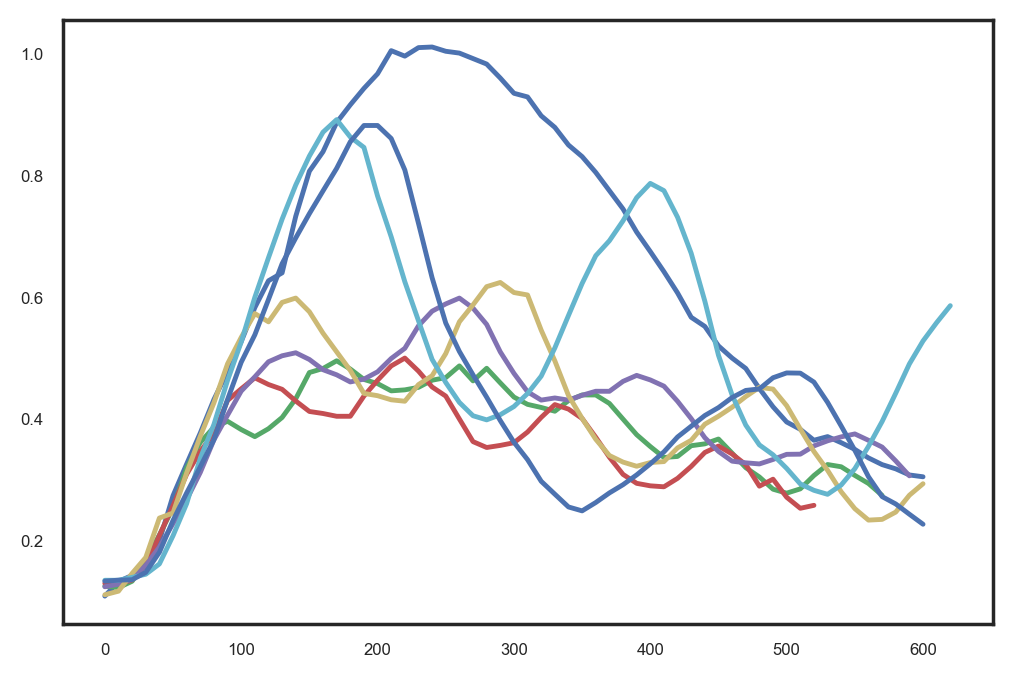

In [16]:
# 10nM Periodic
scorefxn_time = scorefxn_time_10
scorefxn_data = scorefxn_data_10
plt.plot(scorefxn_time[0], scorefxn_data[0], markersize=3)
plt.plot(scorefxn_time[1], [i * 1.0 for i in scorefxn_data[1]], markersize=3)
plt.plot(scorefxn_time[2], [i * 1.0 for i in scorefxn_data[2]], markersize=3)
plt.plot(scorefxn_time[3], [i * 1.0 for i in scorefxn_data[3]], markersize=3)
plt.plot(scorefxn_time[4], [i * 1.0 for i in scorefxn_data[4]], markersize=3)
plt.plot(scorefxn_time[5], [i * 1.0  for i in scorefxn_data[5]], markersize=3)
plt.plot(scorefxn_time[6], [i * 1.0 for i in scorefxn_data[6]], markersize=3)

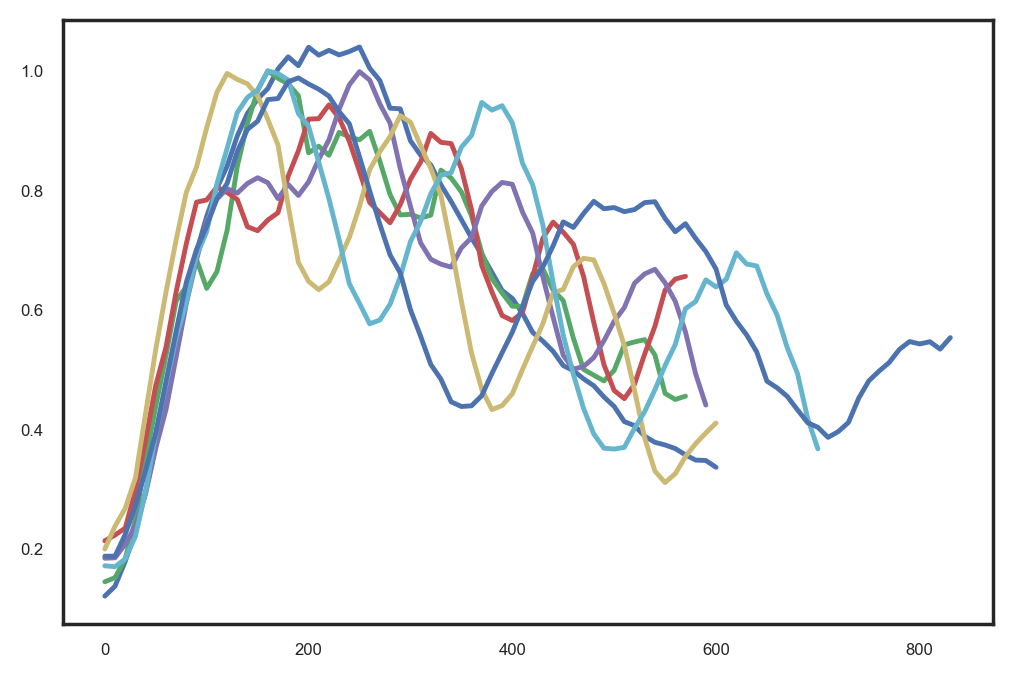

In [17]:
# 50nM Periodic
scorefxn_time = periodic_time
scorefxn_data = periodic_data
plt.plot(scorefxn_time[0], scorefxn_data[0], markersize=3)
plt.plot(scorefxn_time[1], [i * 1.0 for i in scorefxn_data[1]], markersize=3)
plt.plot(scorefxn_time[2], [i * 1.0 for i in scorefxn_data[2]], markersize=3)
plt.plot(scorefxn_time[3], [i * 1.0 for i in scorefxn_data[3]], markersize=3)
plt.plot(scorefxn_time[4], [i * 1.0 for i in scorefxn_data[4]], markersize=3)
plt.plot(scorefxn_time[5], [i * 1.0 for i in scorefxn_data[5]], markersize=3)
plt.plot(scorefxn_time[6], [i * 1.0 for i in scorefxn_data[6]], markersize=3)

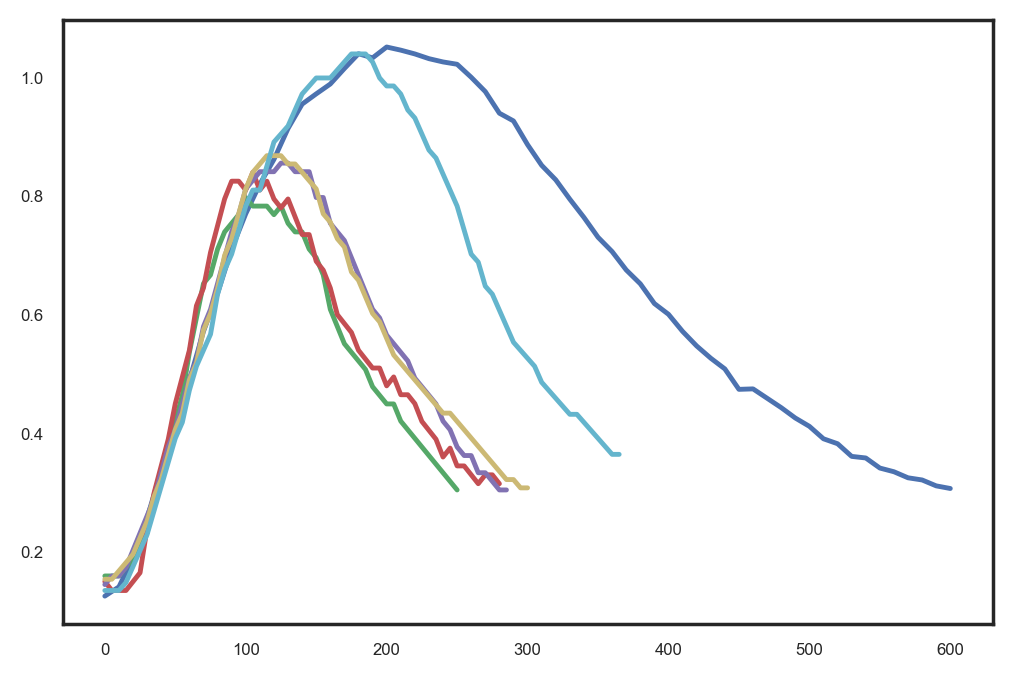

In [18]:
# 50nM Pulse
scorefxn_time = pulse_time
scorefxn_data = pulse_data
plt.plot(scorefxn_time[0], scorefxn_data[0], markersize=3)
plt.plot(scorefxn_time[1], [i * 1.0 for i in scorefxn_data[1]], markersize=3)
plt.plot(scorefxn_time[2], [i * 1.0 for i in scorefxn_data[2]], markersize=3)
plt.plot(scorefxn_time[3], [i * 1.0 for i in scorefxn_data[3]], markersize=3)
plt.plot(scorefxn_time[4], [i * 1.0 for i in scorefxn_data[4]], markersize=3)
plt.plot(scorefxn_time[5], [i * 1.0 for i in scorefxn_data[5]], markersize=3)

# Scale with just scaling factor

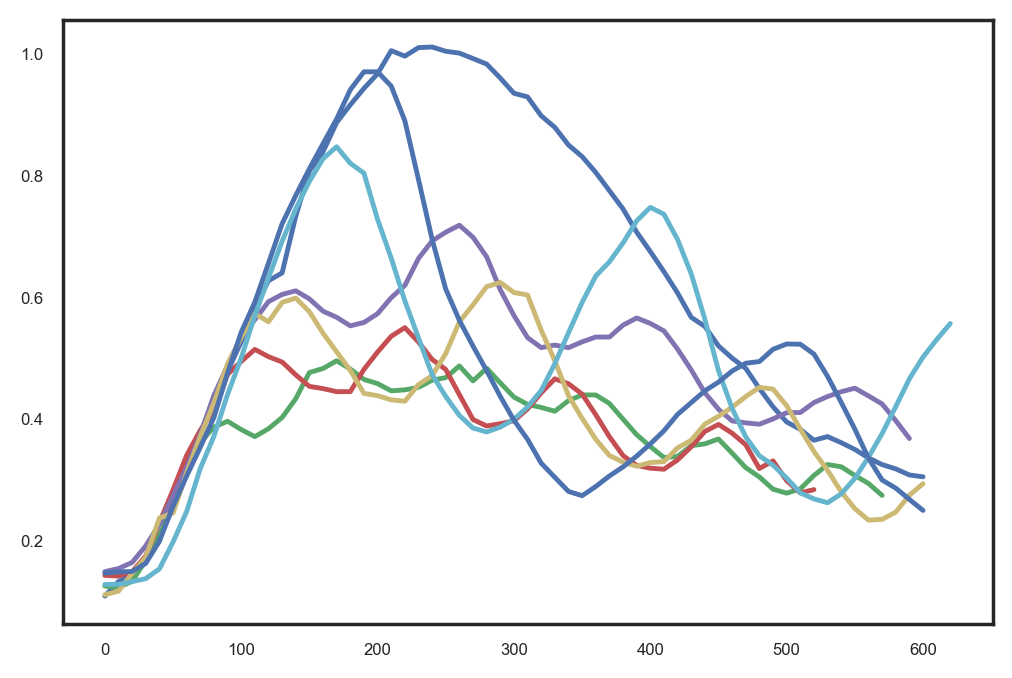

In [19]:
# 10nM Periodic
scorefxn_time = scorefxn_time_10
scorefxn_data = scorefxn_data_10
plt.plot(scorefxn_time[0], scorefxn_data[0], markersize=3)
plt.plot(scorefxn_time[1], [i * 1.0 for i in scorefxn_data[1]], markersize=3)
plt.plot(scorefxn_time[2], [i * 1.1 for i in scorefxn_data[2]], markersize=3)
plt.plot(scorefxn_time[3], [i * 1.2 for i in scorefxn_data[3]], markersize=3)
plt.plot(scorefxn_time[4], [i * 1.0 for i in scorefxn_data[4]], markersize=3)
plt.plot(scorefxn_time[5], [i * 0.95 for i in scorefxn_data[5]], markersize=3)
plt.plot(scorefxn_time[6], [i * 1.1 for i in scorefxn_data[6]], markersize=3)

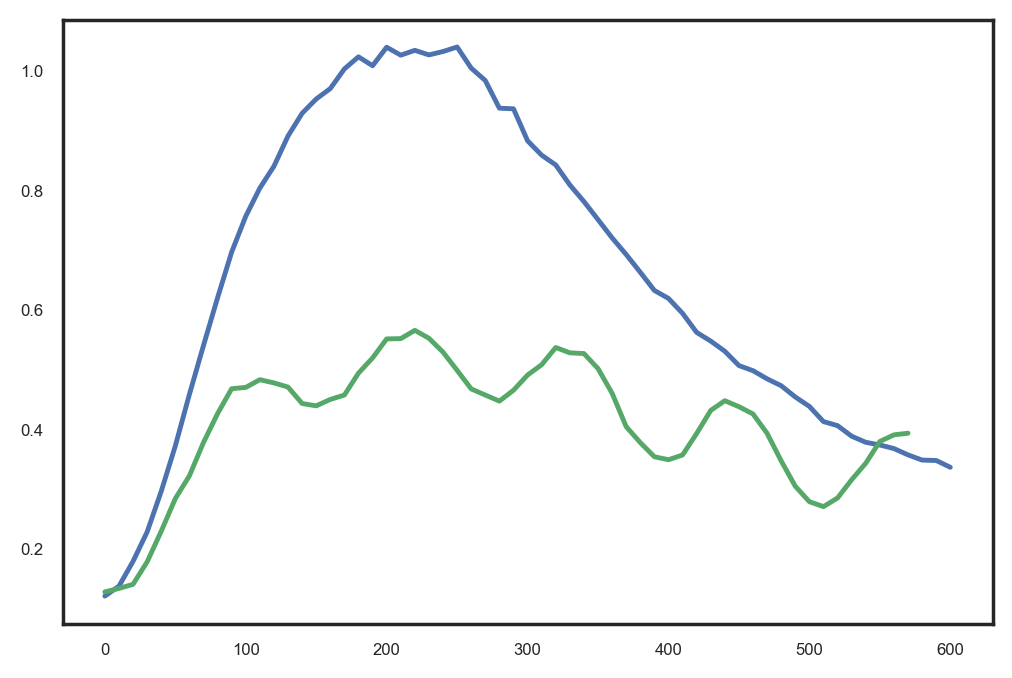

In [45]:
# 50nM Periodic
scorefxn_time = periodic_time
scorefxn_data = periodic_data
plt.plot(scorefxn_time[0], scorefxn_data[0], markersize=3)
# plt.plot(scorefxn_time[1], [i * 0.9 for i in scorefxn_data[1]], markersize=3)
plt.plot(scorefxn_time[2], [i * 0.6 for i in scorefxn_data[2]], markersize=3)
# plt.plot(scorefxn_time[3], [i * 1.1 for i in scorefxn_data[3]], markersize=3)
# plt.plot(scorefxn_time[4], [i * 0.9 for i in scorefxn_data[4]], markersize=3)
# plt.plot(scorefxn_time[5], [i * 1.0 for i in scorefxn_data[5]], markersize=3)
# plt.plot(scorefxn_time[6], [i * 1.1 for i in scorefxn_data[6]], markersize=3)

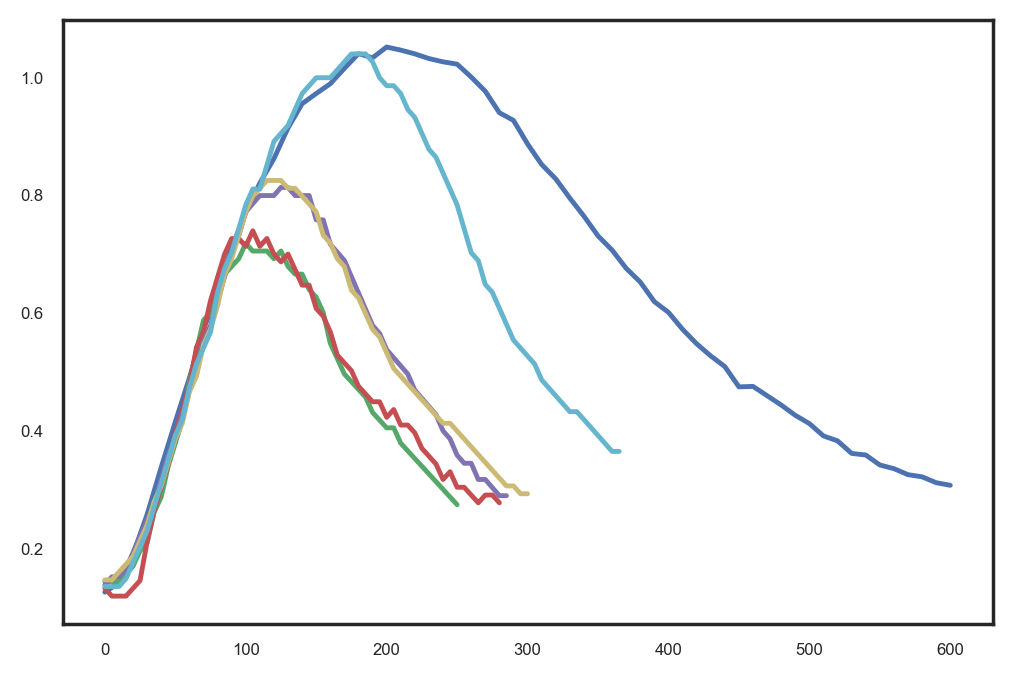

In [21]:
# 50nM Pulse
scorefxn_time = pulse_time
scorefxn_data = pulse_data
plt.plot(scorefxn_time[0], scorefxn_data[0], markersize=3)
plt.plot(scorefxn_time[1], [i * 0.9 for i in scorefxn_data[1]], markersize=3)
plt.plot(scorefxn_time[2], [i * 0.88 - 0.0 for i in scorefxn_data[2]], markersize=3)
plt.plot(scorefxn_time[3], [i * 0.95 - 0.0 for i in scorefxn_data[3]], markersize=3)
plt.plot(scorefxn_time[4], [i * 0.95 - 0.0 for i in scorefxn_data[4]], markersize=3)
plt.plot(scorefxn_time[5], [i * 1.0 for i in scorefxn_data[5]], markersize=3)

# Scale with scaling factor and shift

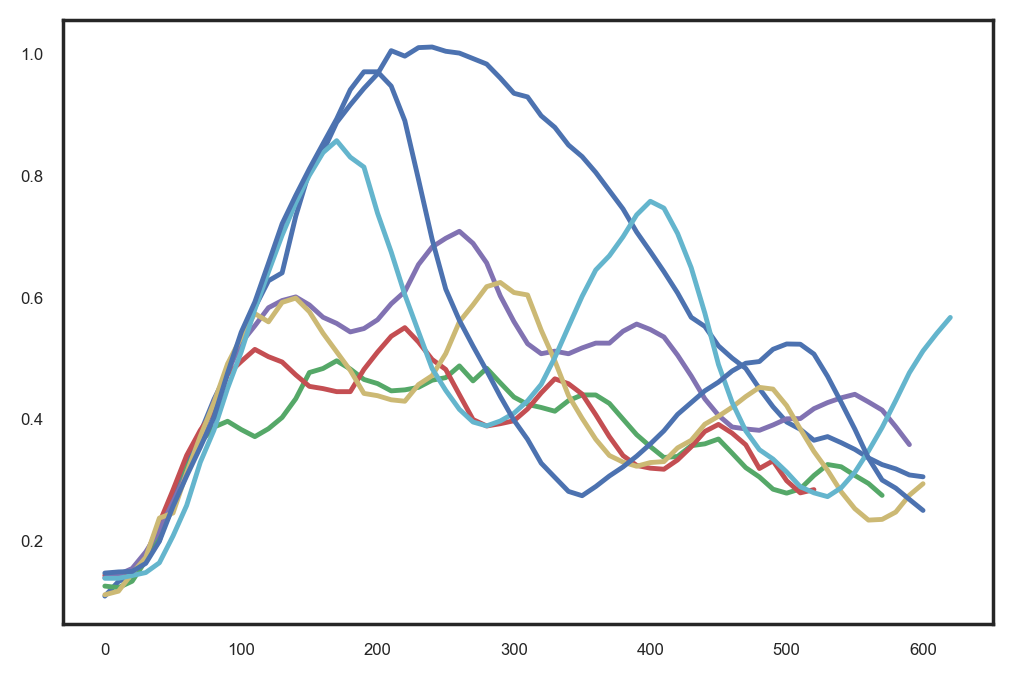

In [9]:
# 10nM Periodic
scorefxn_time = scorefxn_time_10
scorefxn_data = scorefxn_data_10
plt.plot(scorefxn_time[0], scorefxn_data[0], markersize=3)
plt.plot(scorefxn_time[1], [i * 1.0 for i in scorefxn_data[1]], markersize=3)
plt.plot(scorefxn_time[2], [i * 1.1 for i in scorefxn_data[2]], markersize=3)
plt.plot(scorefxn_time[3], [i * 1.2 - 0.01 for i in scorefxn_data[3]], markersize=3)
plt.plot(scorefxn_time[4], [i * 1.0 for i in scorefxn_data[4]], markersize=3)
plt.plot(scorefxn_time[5], [i * 0.95 + 0.01 for i in scorefxn_data[5]], markersize=3)
plt.plot(scorefxn_time[6], [i * 1.1 for i in scorefxn_data[6]], markersize=3)

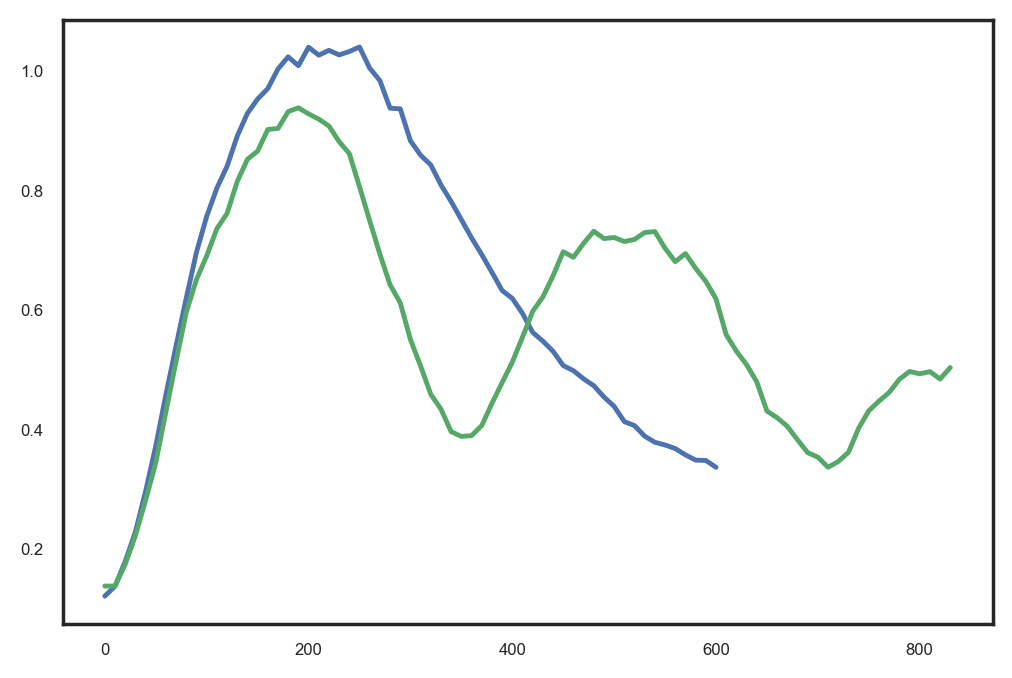

In [40]:
# 50nM Periodic
scorefxn_time = periodic_time
scorefxn_data = periodic_data
plt.plot(scorefxn_time[0], scorefxn_data[0], markersize=3)
# plt.plot(scorefxn_time[1], [i * 1.0 -0.02 for i in scorefxn_data[1]], markersize=3) #0.9
# plt.plot(scorefxn_time[2], [i * 1.0 - 0.1 for i in scorefxn_data[2]], markersize=3) #0.95
# plt.plot(scorefxn_time[3], [i * 1.0 - 0.06 for i in scorefxn_data[3]], markersize=3) #0.95
# plt.plot(scorefxn_time[4], [i * 1.0 - 0.09 for i in scorefxn_data[4]], markersize=3) #0.9
# plt.plot(scorefxn_time[5], [i * 1.0 - 0.05 for i in scorefxn_data[5]], markersize=3)
plt.plot(scorefxn_time[6], [i * 1.0 - 0.05 for i in scorefxn_data[6]], markersize=3) #1.1

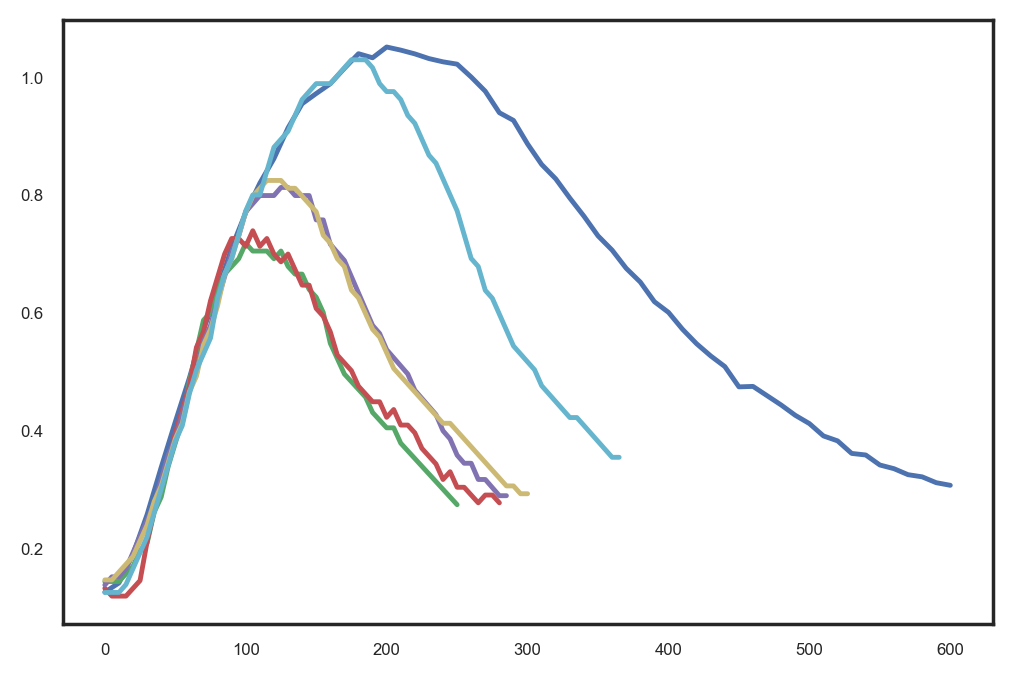

In [12]:
# 50nM Pulse
scorefxn_time = pulse_time
scorefxn_data = pulse_data
plt.plot(scorefxn_time[0], scorefxn_data[0], markersize=3)
plt.plot(scorefxn_time[1], [i * 0.9 for i in scorefxn_data[1]], markersize=3)
plt.plot(scorefxn_time[2], [i * 0.88 - 0.0 for i in scorefxn_data[2]], markersize=3)
plt.plot(scorefxn_time[3], [i * 0.95 - 0.0 for i in scorefxn_data[3]], markersize=3)
plt.plot(scorefxn_time[4], [i * 0.95 - 0.0 for i in scorefxn_data[4]], markersize=3)
plt.plot(scorefxn_time[5], [i * 1.0 - 0.01 for i in scorefxn_data[5]], markersize=3)

# Export Scaled data

In [25]:
# 50nM Periodic
scorefxn_time = periodic_time
scorefxn_data = periodic_data

times = []
times.append(scorefxn_time[0])
times.append(scorefxn_time[1])
times.append(scorefxn_time[2])
times.append(scorefxn_time[3])
times.append(scorefxn_time[4])
times.append(scorefxn_time[5])
times.append(scorefxn_time[6])

data = []
data.append(scorefxn_data[0])
data.append([i * 0.9 for i in scorefxn_data[1]])
data.append([i * 0.95 - 0.05 for i in scorefxn_data[2]])
data.append([i * 1.1 - 0.07 for i in scorefxn_data[3]])
data.append([i * 0.9 - 0.09 for i in scorefxn_data[4]])
data.append([i * 1.0 - 0.01 for i in scorefxn_data[5]])
data.append([i * 1.1 - 0.05 for i in scorefxn_data[6]])

scorefxn_arr = [times, data]
import pickle
filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Experimental Data/50periodic_scaled.pickled'
pickle.dump(scorefxn_arr, open(filename, 'wb'))

In [26]:
# 10nM Periodic
scorefxn_time = scorefxn_time_10
scorefxn_data = scorefxn_data_10

times = []
times.append(scorefxn_time[0])
times.append(scorefxn_time[1])
times.append(scorefxn_time[2])
times.append(scorefxn_time[3])
times.append(scorefxn_time[4])
times.append(scorefxn_time[5])
times.append(scorefxn_time[6])

data = []
data.append(scorefxn_data[0])
data.append([i * 1.0 for i in scorefxn_data[1]])
data.append([i * 1.1 for i in scorefxn_data[2]])
data.append([i * 1.2 - 0.01 for i in scorefxn_data[3]])
data.append([i * 1.0 for i in scorefxn_data[4]])
data.append([i * 0.95 + 0.01 for i in scorefxn_data[5]])
data.append([i * 1.1 for i in scorefxn_data[6]])

scorefxn_arr = [times, data]
import pickle
filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Experimental Data/10periodic_scaled.pickled'
pickle.dump(scorefxn_arr, open(filename, 'wb'))

In [27]:
# 50nM Single Pulse
scorefxn_time = pulse_time
scorefxn_data = pulse_data

times = []
times.append(scorefxn_time[0])
times.append(scorefxn_time[1])
times.append(scorefxn_time[2])
times.append(scorefxn_time[3])
times.append(scorefxn_time[4])
times.append(scorefxn_time[5])
times.append(scorefxn_time[6])

data = []
data.append(scorefxn_data[0])
data.append([i * 0.9 for i in scorefxn_data[1]])
data.append([i * 0.88 - 0.0 for i in scorefxn_data[2]])
data.append([i * 0.95 - 0.0 for i in scorefxn_data[3]])
data.append([i * 0.95 - 0.0 for i in scorefxn_data[4]])
data.append([i * 1.0 - 0.01 for i in scorefxn_data[5]])

scorefxn_arr = [times, data]
import pickle
filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Experimental Data/50pulse_scaled.pickled'
pickle.dump(scorefxn_arr, open(filename, 'wb'))